In [1]:
# pip install numpy==1.18.2

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking
from tensorflow.keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt
import numpy.ma as ma

In [3]:
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20,12)
figure(figsize=(100, 80), dpi=80)

<Figure size 8000x6400 with 0 Axes>

<Figure size 8000x6400 with 0 Axes>

In [4]:
tf.random.set_seed(12345)

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [6]:
f = h5py.File("plazamont_processed_data.h5","r")
scaled_X = ma.array(f["scaled_x"])
scaled_X.mask = ma.array(f["x_mask"])
minX = np.array(f["minX"])
maxX = np.array(f["maxX"])
f.close()

In [7]:
scaled_X

masked_array(
  data=[[0.1956745623069001],
        [0.1730175077239959],
        [0.1761071060762101],
        [0.15550978372811536],
        [0.16374871266735327],
        [0.16786817713697222],
        [0.14727085478887747],
        [0.14727085478887747],
        [0.22966014418125646],
        [0.15036045314109167],
        [0.13285272914521112],
        [0.141091658084449],
        [0.15550978372811536],
        [0.16168898043254376],
        [0.2008238928939238],
        [0.23789907312049433],
        [0.35015447991761073],
        [0.4335736354273944],
        [0.4696189495365602],
        [0.4984552008238929],
        [0.4830072090628218],
        [0.5417095777548918],
        [0.49433573635427397],
        [0.5036045314109165],
        [0.49742533470648814],
        [0.46446961894953653],
        [0.46446961894953653],
        [0.45417095777548916],
        [0.431513903192585],
        [0.42327497425334704],
        [0.35427394438722964],
        [0.3563336766220392],
        [

In [8]:
def inverse_scaler(scaled_x,minX,maxX):
    return scaled_x*maxX-minX

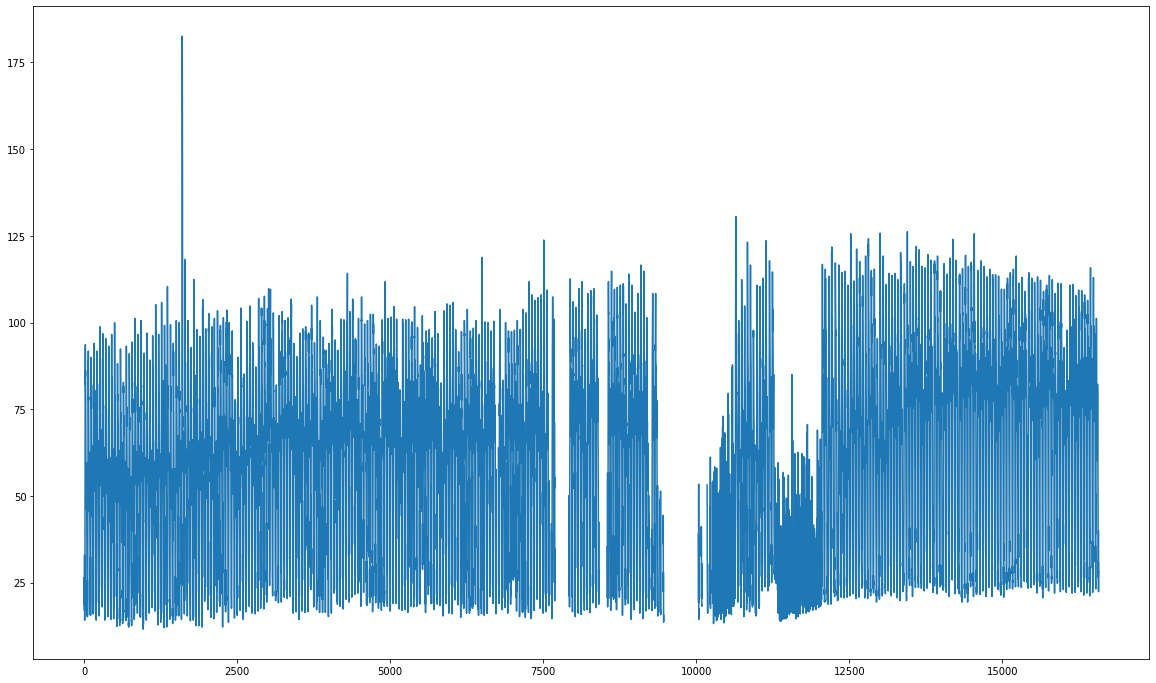

In [9]:
plt.plot(inverse_scaler(scaled_X,minX,maxX))
plt.show()

In [10]:
def partitionSet(test_fraction, data, partitions):
    lenX = len(data)
    test_size = int(len(data) * test_fraction)
    test_df = data[int((partitions/100)*lenX):int((partitions/100)*lenX)+test_size]
    train_df = ma.vstack((data[:int((partitions/100)*lenX)-1],data[int((partitions/100)*lenX)+test_size:]))
    train_df[int((partitions/100)*lenX)] = ma.masked
    return train_df, test_df

train_dataf = []
test_dataf = []

partitions=75

for i in range(1, partitions):
    [train_df,test_df] = partitionSet(0.25,scaled_X,i)
    train_dataf.append(train_df)
    test_dataf.append(test_df)

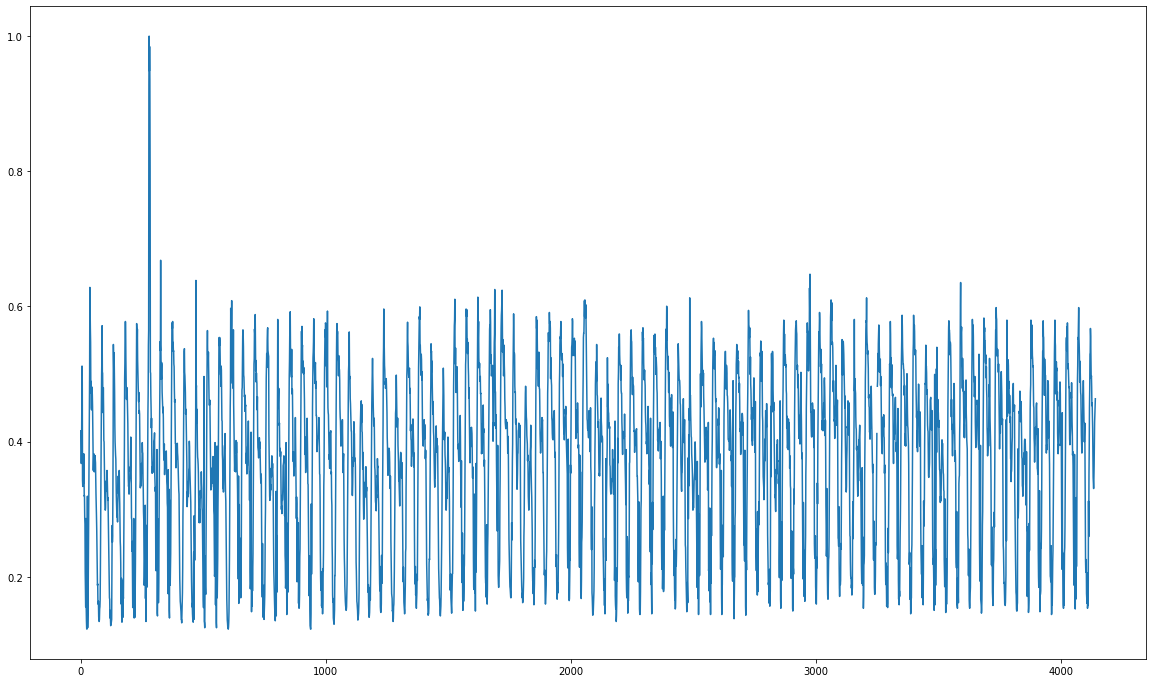

In [11]:
plt.plot(test_dataf[7])
plt.show()

In [12]:
def Dataset(train, test, timesteps):
    X_train = ma.array([train[t:t+timesteps] for t in range(0,len(train)-timesteps)])
    y_train = train[timesteps:, :]
    X_test = ma.array([test[t:t+timesteps] for t in range(0,len(test)-timesteps)])
    y_test = test[timesteps:, :]
    return X_train, y_train, X_test, y_test

train_X_data = []
train_Y_data = []
test_X_data = []
test_Y_data = []


for j in range(0, len(train_dataf)):
    [train_X_dates,train_Y_dates,test_X_dates,test_Y_dates]=Dataset(train_dataf[j],test_dataf[j], 24)
    train_X_data.append(train_X_dates)
    train_Y_data.append(train_Y_dates)
    test_X_data.append(test_X_dates)
    test_Y_data.append(test_Y_dates)

In [13]:
with open('train_X_data.npy', 'wb') as f:
    np.save(f, [train_X_data[i] for i in range(0, len(train_dataf))])

In [14]:
with open('train_Y_data.npy', 'wb') as f:
    np.save(f, [train_Y_data[i] for i in range(0, len(train_dataf))])

In [15]:
with open('test_X_data.npy', 'wb') as f:
    np.save(f, [test_X_data[i] for i in range(0, len(train_dataf))])

In [16]:
with open('test_Y_data.npy', 'wb') as f:
    np.save(f, [test_Y_data[i] for i in range(0, len(train_dataf))])

In [19]:
def LSTM_function(NCells, timesteps, num_features, dropout, NBEpochs, Batchsize, validationSplit, i):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(timesteps, num_features)))
    model.add(LSTM(1, activation = 'tanh', input_shape = (timesteps, num_features), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(NCells))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    opt = Adam(learning_rate=0.0002)
    model.compile(loss = 'mse', optimizer=opt)
    X_ = ma.filled(train_X_data[i],0)
    Y_ = ma.filled(train_Y_data[i],0)
    MODEL = model.fit(X_, Y_, epochs = NBEpochs, batch_size = Batchsize,
                      validation_split = validationSplit, shuffle = False)
    return model, MODEL

In [20]:
df_train = []
df_validation = []
models = []
MODELS = []

datasets = np.arange(0,partitions-1)

for j in datasets:
    [model, MODEL] = LSTM_function(32,np.shape(train_X_data[0])[1], 1, 0.15, 60, 256, 0.2, j)
    df_train.append(MODEL.history['loss'])
    df_validation.append(MODEL.history['val_loss'])
    models.append(model)
    MODELS.append(MODEL)

Epoch 1/60
39/39 [==============================] - 7s 77ms/step - loss: 0.1070 - val_loss: 0.1291
Epoch 2/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0550 - val_loss: 0.0519
Epoch 3/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0233 - val_loss: 0.0250
Epoch 4/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0204 - val_loss: 0.0264
Epoch 5/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0203 - val_loss: 0.0260
Epoch 6/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0204 - val_loss: 0.0259
Epoch 7/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0203 - val_loss: 0.0256
Epoch 8/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0198 - val_loss: 0.0254
Epoch 9/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0195 - val_loss: 0.0252
Epoch 10/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0195 - val_loss: 0.0247
Epoch 11/

39/39 [==============================] - 1s 33ms/step - loss: 0.0175 - val_loss: 0.0228
Epoch 24/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0172 - val_loss: 0.0225
Epoch 25/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0173 - val_loss: 0.0224
Epoch 26/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0170 - val_loss: 0.0219
Epoch 27/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0166 - val_loss: 0.0217
Epoch 28/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0166 - val_loss: 0.0212
Epoch 29/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0164 - val_loss: 0.0209
Epoch 30/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0162 - val_loss: 0.0207
Epoch 31/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0158 - val_loss: 0.0203
Epoch 32/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0157 - val_loss: 0.0202
Epoch 33/60


39/39 [==============================] - 1s 33ms/step - loss: 0.0202 - val_loss: 0.0281
Epoch 8/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0200 - val_loss: 0.0281
Epoch 9/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0198 - val_loss: 0.0277
Epoch 10/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0199 - val_loss: 0.0276
Epoch 11/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0196 - val_loss: 0.0273
Epoch 12/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0195 - val_loss: 0.0271
Epoch 13/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0193 - val_loss: 0.0269
Epoch 14/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0192 - val_loss: 0.0268
Epoch 15/60
39/39 [==============================] - 1s 35ms/step - loss: 0.0192 - val_loss: 0.0267
Epoch 16/60
39/39 [==============================] - 1s 36ms/step - loss: 0.0191 - val_loss: 0.0262
Epoch 17/60
39

39/39 [==============================] - 1s 32ms/step - loss: 0.0149 - val_loss: 0.0197
Epoch 52/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0149 - val_loss: 0.0196
Epoch 53/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0146 - val_loss: 0.0192
Epoch 54/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0147 - val_loss: 0.0191
Epoch 55/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0147 - val_loss: 0.0190
Epoch 56/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0145 - val_loss: 0.0186
Epoch 57/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0142 - val_loss: 0.0183
Epoch 58/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0141 - val_loss: 0.0182
Epoch 59/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0140 - val_loss: 0.0183
Epoch 60/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0141 - val_loss: 0.0184
Epoch 1/60
3

39/39 [==============================] - 1s 31ms/step - loss: 0.0138 - val_loss: 0.0167
Epoch 36/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0140 - val_loss: 0.0164
Epoch 37/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0136 - val_loss: 0.0163
Epoch 38/60
39/39 [==============================] - 1s 35ms/step - loss: 0.0137 - val_loss: 0.0163
Epoch 39/60
39/39 [==============================] - 1s 35ms/step - loss: 0.0135 - val_loss: 0.0162
Epoch 40/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0136 - val_loss: 0.0162
Epoch 41/60
39/39 [==============================] - 1s 36ms/step - loss: 0.0134 - val_loss: 0.0158
Epoch 42/60
39/39 [==============================] - 1s 35ms/step - loss: 0.0135 - val_loss: 0.0158
Epoch 43/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0134 - val_loss: 0.0156
Epoch 44/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0133 - val_loss: 0.0155
Epoch 45/60


39/39 [==============================] - 1s 35ms/step - loss: 0.0165 - val_loss: 0.0206
Epoch 20/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0161 - val_loss: 0.0203
Epoch 21/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0158 - val_loss: 0.0200
Epoch 22/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0157 - val_loss: 0.0193
Epoch 23/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0155 - val_loss: 0.0190
Epoch 24/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0152 - val_loss: 0.0186
Epoch 25/60
39/39 [==============================] - 1s 33ms/step - loss: 0.0152 - val_loss: 0.0183
Epoch 26/60
39/39 [==============================] - 1s 35ms/step - loss: 0.0148 - val_loss: 0.0176
Epoch 27/60
39/39 [==============================] - 1s 34ms/step - loss: 0.0143 - val_loss: 0.0174
Epoch 28/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0144 - val_loss: 0.0168
Epoch 29/60


39/39 [==============================] - 1s 32ms/step - loss: 0.0230 - val_loss: 0.0340
Epoch 4/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0216 - val_loss: 0.0310
Epoch 5/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0216 - val_loss: 0.0314
Epoch 6/60
39/39 [==============================] - 1s 29ms/step - loss: 0.0217 - val_loss: 0.0317
Epoch 7/60
39/39 [==============================] - 1s 30ms/step - loss: 0.0216 - val_loss: 0.0313
Epoch 8/60
39/39 [==============================] - 1s 30ms/step - loss: 0.0213 - val_loss: 0.0312
Epoch 9/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0214 - val_loss: 0.0312
Epoch 10/60
39/39 [==============================] - 1s 29ms/step - loss: 0.0213 - val_loss: 0.0309
Epoch 11/60
39/39 [==============================] - 1s 29ms/step - loss: 0.0211 - val_loss: 0.0307
Epoch 12/60
39/39 [==============================] - 1s 29ms/step - loss: 0.0212 - val_loss: 0.0307
Epoch 13/60
39/39 

39/39 [==============================] - 1s 31ms/step - loss: 0.0152 - val_loss: 0.0206
Epoch 48/60
39/39 [==============================] - 1s 30ms/step - loss: 0.0148 - val_loss: 0.0203
Epoch 49/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0146 - val_loss: 0.0202
Epoch 50/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0143 - val_loss: 0.0199
Epoch 51/60
39/39 [==============================] - 1s 30ms/step - loss: 0.0143 - val_loss: 0.0195
Epoch 52/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0140 - val_loss: 0.0194
Epoch 53/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0139 - val_loss: 0.0190
Epoch 54/60
39/39 [==============================] - 1s 32ms/step - loss: 0.0139 - val_loss: 0.0187
Epoch 55/60
39/39 [==============================] - 1s 30ms/step - loss: 0.0137 - val_loss: 0.0184
Epoch 56/60
39/39 [==============================] - 1s 30ms/step - loss: 0.0135 - val_loss: 0.0182
Epoch 57/60


39/39 [==============================] - 1s 31ms/step - loss: 0.0189 - val_loss: 0.0246
Epoch 32/60
39/39 [==============================] - 1s 30ms/step - loss: 0.0189 - val_loss: 0.0246
Epoch 33/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0189 - val_loss: 0.0243
Epoch 34/60
39/39 [==============================] - 1s 29ms/step - loss: 0.0186 - val_loss: 0.0241
Epoch 35/60
39/39 [==============================] - 1s 29ms/step - loss: 0.0184 - val_loss: 0.0237
Epoch 36/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0185 - val_loss: 0.0236
Epoch 37/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0182 - val_loss: 0.0234
Epoch 38/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0180 - val_loss: 0.0230
Epoch 39/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0178 - val_loss: 0.0229
Epoch 40/60
39/39 [==============================] - 1s 31ms/step - loss: 0.0179 - val_loss: 0.0228
Epoch 41/60


39/39 [==============================] - 1s 27ms/step - loss: 0.0175 - val_loss: 0.0231
Epoch 16/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0175 - val_loss: 0.0228
Epoch 17/60
39/39 [==============================] - 1s 29ms/step - loss: 0.0173 - val_loss: 0.0225
Epoch 18/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0169 - val_loss: 0.0223
Epoch 19/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0171 - val_loss: 0.0220
Epoch 20/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0166 - val_loss: 0.0215
Epoch 21/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0164 - val_loss: 0.0212
Epoch 22/60
39/39 [==============================] - 1s 29ms/step - loss: 0.0162 - val_loss: 0.0207
Epoch 23/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0160 - val_loss: 0.0205
Epoch 24/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0158 - val_loss: 0.0203
Epoch 25/60


39/39 [==============================] - 1s 26ms/step - loss: 0.0130 - val_loss: 0.0144
Epoch 60/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0129 - val_loss: 0.0143
Epoch 1/60
39/39 [==============================] - 7s 61ms/step - loss: 0.0968 - val_loss: 0.1075
Epoch 2/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0405 - val_loss: 0.0362
Epoch 3/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0191 - val_loss: 0.0233
Epoch 4/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0185 - val_loss: 0.0242
Epoch 5/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0185 - val_loss: 0.0239
Epoch 6/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0183 - val_loss: 0.0236
Epoch 7/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0182 - val_loss: 0.0233
Epoch 8/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0179 - val_loss: 0.0231
Epoch 9/60
39/39 [==

39/39 [==============================] - 1s 25ms/step - loss: 0.0178 - val_loss: 0.0248
Epoch 44/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0177 - val_loss: 0.0245
Epoch 45/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0174 - val_loss: 0.0241
Epoch 46/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0173 - val_loss: 0.0239
Epoch 47/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0173 - val_loss: 0.0236
Epoch 48/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0169 - val_loss: 0.0233
Epoch 49/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0169 - val_loss: 0.0231
Epoch 50/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0167 - val_loss: 0.0228
Epoch 51/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0166 - val_loss: 0.0225
Epoch 52/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0164 - val_loss: 0.0221
Epoch 53/60


39/39 [==============================] - 1s 21ms/step - loss: 0.0124 - val_loss: 0.0153
Epoch 28/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0125 - val_loss: 0.0147
Epoch 29/60
39/39 [==============================] - 1s 20ms/step - loss: 0.0123 - val_loss: 0.0143
Epoch 30/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0122 - val_loss: 0.0142
Epoch 31/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0121 - val_loss: 0.0139
Epoch 32/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0119 - val_loss: 0.0139
Epoch 33/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0119 - val_loss: 0.0137
Epoch 34/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0118 - val_loss: 0.0135
Epoch 35/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0116 - val_loss: 0.0131
Epoch 36/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0115 - val_loss: 0.0130
Epoch 37/60


39/39 [==============================] - 1s 19ms/step - loss: 0.0225 - val_loss: 0.0299
Epoch 12/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0228 - val_loss: 0.0299
Epoch 13/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0226 - val_loss: 0.0296
Epoch 14/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0225 - val_loss: 0.0299
Epoch 15/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0224 - val_loss: 0.0297
Epoch 16/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0225 - val_loss: 0.0295
Epoch 17/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0223 - val_loss: 0.0296
Epoch 18/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0222 - val_loss: 0.0295
Epoch 19/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0222 - val_loss: 0.0294
Epoch 20/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0220 - val_loss: 0.0293
Epoch 21/60


39/39 [==============================] - 1s 15ms/step - loss: 0.0115 - val_loss: 0.0121
Epoch 34/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0114 - val_loss: 0.0120
Epoch 35/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 36/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 37/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 38/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0109 - val_loss: 0.0111
Epoch 39/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 40/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 41/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 42/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0106 - val_loss: 0.0104
Epoch 43/60


39/39 [==============================] - 1s 13ms/step - loss: 0.0167 - val_loss: 0.0202
Epoch 18/60
39/39 [==============================] - 1s 14ms/step - loss: 0.0165 - val_loss: 0.0199
Epoch 19/60
39/39 [==============================] - 1s 14ms/step - loss: 0.0163 - val_loss: 0.0196
Epoch 20/60
39/39 [==============================] - 1s 14ms/step - loss: 0.0159 - val_loss: 0.0192
Epoch 21/60
39/39 [==============================] - 1s 14ms/step - loss: 0.0156 - val_loss: 0.0188
Epoch 22/60
39/39 [==============================] - 1s 14ms/step - loss: 0.0153 - val_loss: 0.0183
Epoch 23/60
39/39 [==============================] - 1s 13ms/step - loss: 0.0151 - val_loss: 0.0179
Epoch 24/60
39/39 [==============================] - 1s 14ms/step - loss: 0.0147 - val_loss: 0.0175
Epoch 25/60
39/39 [==============================] - 1s 14ms/step - loss: 0.0147 - val_loss: 0.0172
Epoch 26/60
39/39 [==============================] - 1s 14ms/step - loss: 0.0140 - val_loss: 0.0164
Epoch 27/60


39/39 [==============================] - 7s 55ms/step - loss: 0.1329 - val_loss: 0.1459
Epoch 2/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0647 - val_loss: 0.0489
Epoch 3/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0224 - val_loss: 0.0281
Epoch 4/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0212 - val_loss: 0.0273
Epoch 5/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0212 - val_loss: 0.0275
Epoch 6/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0213 - val_loss: 0.0276
Epoch 7/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0208 - val_loss: 0.0272
Epoch 8/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0207 - val_loss: 0.0270
Epoch 9/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0206 - val_loss: 0.0270
Epoch 10/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0205 - val_loss: 0.0268
Epoch 11/60
39/39 [=

39/39 [==============================] - 1s 15ms/step - loss: 0.0115 - val_loss: 0.0123
Epoch 46/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 47/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0114 - val_loss: 0.0119
Epoch 48/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0111 - val_loss: 0.0119
Epoch 49/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 50/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0109 - val_loss: 0.0115
Epoch 51/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 52/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0108 - val_loss: 0.0111
Epoch 53/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0107 - val_loss: 0.0110
Epoch 54/60
39/39 [==============================] - 1s 15ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 55/60


39/39 [==============================] - 1s 16ms/step - loss: 0.0163 - val_loss: 0.0182
Epoch 30/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0159 - val_loss: 0.0178
Epoch 31/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0155 - val_loss: 0.0172
Epoch 32/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0150 - val_loss: 0.0167
Epoch 33/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0145 - val_loss: 0.0160
Epoch 34/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0141 - val_loss: 0.0155
Epoch 35/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0137 - val_loss: 0.0150
Epoch 36/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 37/60
39/39 [==============================] - 1s 16ms/step - loss: 0.0130 - val_loss: 0.0140
Epoch 38/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0128 - val_loss: 0.0139
Epoch 39/60


39/39 [==============================] - 1s 19ms/step - loss: 0.0192 - val_loss: 0.0227
Epoch 14/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0192 - val_loss: 0.0226
Epoch 15/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0189 - val_loss: 0.0223
Epoch 16/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0187 - val_loss: 0.0221
Epoch 17/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0187 - val_loss: 0.0219
Epoch 18/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0185 - val_loss: 0.0218
Epoch 19/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0184 - val_loss: 0.0215
Epoch 20/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0181 - val_loss: 0.0213
Epoch 21/60
39/39 [==============================] - 1s 17ms/step - loss: 0.0179 - val_loss: 0.0211
Epoch 22/60
39/39 [==============================] - 1s 18ms/step - loss: 0.0177 - val_loss: 0.0209
Epoch 23/60


39/39 [==============================] - 1s 20ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 58/60
39/39 [==============================] - 1s 19ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 59/60
39/39 [==============================] - 1s 19ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 60/60
39/39 [==============================] - 1s 19ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 1/60
39/39 [==============================] - 7s 61ms/step - loss: 0.0822 - val_loss: 0.0719
Epoch 2/60
39/39 [==============================] - 1s 20ms/step - loss: 0.0274 - val_loss: 0.0203
Epoch 3/60
39/39 [==============================] - 1s 20ms/step - loss: 0.0175 - val_loss: 0.0204
Epoch 4/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0169 - val_loss: 0.0196
Epoch 5/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0167 - val_loss: 0.0192
Epoch 6/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0162 - val_loss: 0.0186
Epoch 7/60
39/39 [

39/39 [==============================] - 1s 21ms/step - loss: 0.0178 - val_loss: 0.0214
Epoch 42/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0177 - val_loss: 0.0212
Epoch 43/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0177 - val_loss: 0.0212
Epoch 44/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0176 - val_loss: 0.0210
Epoch 45/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0174 - val_loss: 0.0208
Epoch 46/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0174 - val_loss: 0.0207
Epoch 47/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0174 - val_loss: 0.0205
Epoch 48/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0170 - val_loss: 0.0203
Epoch 49/60
39/39 [==============================] - 1s 21ms/step - loss: 0.0169 - val_loss: 0.0201
Epoch 50/60
39/39 [==============================] - 1s 20ms/step - loss: 0.0169 - val_loss: 0.0199
Epoch 51/60


39/39 [==============================] - 1s 23ms/step - loss: 0.0183 - val_loss: 0.0223
Epoch 26/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0178 - val_loss: 0.0218
Epoch 27/60
39/39 [==============================] - 1s 23ms/step - loss: 0.0176 - val_loss: 0.0217
Epoch 28/60
39/39 [==============================] - 1s 23ms/step - loss: 0.0171 - val_loss: 0.0213
Epoch 29/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0167 - val_loss: 0.0209
Epoch 30/60
39/39 [==============================] - 1s 22ms/step - loss: 0.0161 - val_loss: 0.0209
Epoch 31/60
39/39 [==============================] - 1s 23ms/step - loss: 0.0154 - val_loss: 0.0201
Epoch 32/60
39/39 [==============================] - 1s 23ms/step - loss: 0.0149 - val_loss: 0.0197
Epoch 33/60
39/39 [==============================] - 1s 23ms/step - loss: 0.0147 - val_loss: 0.0193
Epoch 34/60
39/39 [==============================] - 1s 23ms/step - loss: 0.0144 - val_loss: 0.0193
Epoch 35/60


39/39 [==============================] - 1s 26ms/step - loss: 0.0175 - val_loss: 0.0212
Epoch 10/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0175 - val_loss: 0.0209
Epoch 11/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0172 - val_loss: 0.0208
Epoch 12/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0170 - val_loss: 0.0205
Epoch 13/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0168 - val_loss: 0.0203
Epoch 14/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0169 - val_loss: 0.0201
Epoch 15/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0167 - val_loss: 0.0199
Epoch 16/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0163 - val_loss: 0.0196
Epoch 17/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0165 - val_loss: 0.0193
Epoch 18/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0163 - val_loss: 0.0192
Epoch 19/60


39/39 [==============================] - 1s 25ms/step - loss: 0.0106 - val_loss: 0.0130
Epoch 54/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0105 - val_loss: 0.0128
Epoch 55/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0102 - val_loss: 0.0126
Epoch 56/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0101 - val_loss: 0.0124
Epoch 57/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0099 - val_loss: 0.0121
Epoch 58/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0100 - val_loss: 0.0119
Epoch 59/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0097 - val_loss: 0.0117
Epoch 60/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0095 - val_loss: 0.0114
Epoch 1/60
39/39 [==============================] - 7s 65ms/step - loss: 0.1019 - val_loss: 0.0794
Epoch 2/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0411 - val_loss: 0.0226
Epoch 3/60
39/

39/39 [==============================] - 1s 27ms/step - loss: 0.0111 - val_loss: 0.0144
Epoch 38/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0112 - val_loss: 0.0143
Epoch 39/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0111 - val_loss: 0.0141
Epoch 40/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0109 - val_loss: 0.0140
Epoch 41/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0107 - val_loss: 0.0140
Epoch 42/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0106 - val_loss: 0.0139
Epoch 43/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0107 - val_loss: 0.0138
Epoch 44/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0105 - val_loss: 0.0137
Epoch 45/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0104 - val_loss: 0.0136
Epoch 46/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0103 - val_loss: 0.0135
Epoch 47/60


39/39 [==============================] - 1s 26ms/step - loss: 0.0129 - val_loss: 0.0161
Epoch 22/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0124 - val_loss: 0.0163
Epoch 23/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0123 - val_loss: 0.0164
Epoch 24/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0121 - val_loss: 0.0164
Epoch 25/60
39/39 [==============================] - 1s 24ms/step - loss: 0.0120 - val_loss: 0.0164
Epoch 26/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0117 - val_loss: 0.0163
Epoch 27/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0117 - val_loss: 0.0159
Epoch 28/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0114 - val_loss: 0.0158
Epoch 29/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0113 - val_loss: 0.0158
Epoch 30/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0114 - val_loss: 0.0155
Epoch 31/60


39/39 [==============================] - 1s 26ms/step - loss: 0.0177 - val_loss: 0.0176
Epoch 6/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0175 - val_loss: 0.0177
Epoch 7/60
39/39 [==============================] - 1s 28ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 8/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0169 - val_loss: 0.0181
Epoch 9/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0168 - val_loss: 0.0182
Epoch 10/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0165 - val_loss: 0.0184
Epoch 11/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0165 - val_loss: 0.0184
Epoch 12/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0164 - val_loss: 0.0186
Epoch 13/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0160 - val_loss: 0.0188
Epoch 14/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0160 - val_loss: 0.0188
Epoch 15/60
39/3

39/39 [==============================] - 1s 25ms/step - loss: 0.0141 - val_loss: 0.0366
Epoch 50/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0142 - val_loss: 0.0371
Epoch 51/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0142 - val_loss: 0.0375
Epoch 52/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0142 - val_loss: 0.0367
Epoch 53/60
39/39 [==============================] - 1s 27ms/step - loss: 0.0141 - val_loss: 0.0374
Epoch 54/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0142 - val_loss: 0.0365
Epoch 55/60
39/39 [==============================] - 1s 25ms/step - loss: 0.0139 - val_loss: 0.0376
Epoch 56/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0138 - val_loss: 0.0382
Epoch 57/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0137 - val_loss: 0.0386
Epoch 58/60
39/39 [==============================] - 1s 26ms/step - loss: 0.0138 - val_loss: 0.0374
Epoch 59/60


In [21]:
for i in datasets:
    models[i].save('/home/costa/Institute/ModelsForAlicante/PzaMont/models/PzaMontModel'+str(i)+'.h5')

In [22]:
train_performance = []
for i in datasets:
    train_performance.append(np.array(df_train[i]))

In [23]:
val_performance = []
for i in datasets:
    val_performance.append(np.array(df_validation[i]))

In [24]:
with open('train_performance.npy', 'wb') as f:
    np.save(f, [train_performance[i] for i in datasets])

In [25]:
with open('val_performance.npy', 'wb') as f:
    np.save(f, [val_performance[i] for i in datasets])

In [1]:
import re #python regular expression matching module
script = re.sub(r'# In\[.*\]:\n','',open('3.0-Model.py').read())
with open('3.0-ModelScript.py','w') as fh:
    fh.write(script)